In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [2]:
nonface_dataset_path = 'nonface_archive'
face_dataset_path = 'archive'

nonface_dirs, face_dirs = os.listdir(nonface_dataset_path), os.listdir(face_dataset_path)
nonface_data, face_data = np.zeros((400,10304)), np.zeros((400,10304))
nonface_labels, face_labels = np.zeros((400,1)), np.ones((400,1))

cnt=0
paths = ["archive/s" + str(i) for i in range(1,41)]
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)
        np_img = np.array(img)
        np_img = np_img.flatten()
        face_data[cnt]=np_img
        cnt+=1

cnt=0
paths = ["nonface_archive/s" + str(i) for i in range(1,9)]
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)
        np_img = np.array(img)
        np_img = np_img[:,:,0].flatten()
        nonface_data[cnt] = np_img
        cnt += 1

In [3]:
def process_splits(face_data, nonface_data, face_labels, nonface_labels, nonface_cnt=400):

    nonface_data = nonface_data[ 0 : nonface_cnt ]

    data = np.append( face_data, nonface_data, axis=0 )
    labels = np.append( face_labels, nonface_labels, axis=0 )

    # Training set and labels are composed of elements at even indices
    training_set = data[ 0 : len(data) : 2 ]
    training_labels = labels[ 0 : len(data) : 2 ]

    # Test set and labels are composed of elements at odd indices
    test_set = data[ 1 : len(data) : 2 ]
    test_labels = labels[ 1 : len(data) : 2 ]

    return training_set, test_set, training_labels, test_labels

In [4]:
def process_data_PCA(training_set, test_set):
    means = np.mean( training_set, axis=0 )

    # we need to reshape the means vector to be a row vector to be able to broadcast it with the training set and test set
    means = means.reshape( 1, 10304 )

    centered_training_set = training_set - means
    centered_test_set = test_set - means

    # bias=True is used to divide by N instead of N-1 (where N is the number of samples)
    covariance_matrix = np.cov( centered_training_set.T, bias=True )
    
    # we use eigh instead of eig because the covariance matrix is symmetric and won't have complex eigenvalues
    # (eigh is faster and doesn't compute the eigenvectors of the complex conjugate pairs which are not needed)
    eigenvalues, eigenvectors = np.linalg.eigh( covariance_matrix )

    positions = eigenvalues.argsort()[::-1]
    sorted_eigenvalues = ( eigenvalues[positions] )
    sorted_eigenvectors = ( eigenvectors[:, positions] )
        
    return sorted_eigenvalues, sorted_eigenvectors, centered_training_set, centered_test_set

In [5]:
def PCA(eigenvalues, eigenvectors, alpha):
    total = sum( eigenvalues )
    r = 0
    current_sum = 0
    while current_sum / total < alpha:
        current_sum += eigenvalues[r]
        r += 1
    new_space = eigenvectors[:, :r]
    return new_space

### Classification using PCA

In [6]:
scores = []

# Best alpha from the PCA section is 0.8
alpha = 0.8

for nonface_cnt in range( 50, len(nonface_data) + 1, 50 ):
    
    print( '[PCA] Running for', nonface_cnt, 'non-face images\n', nonface_cnt // 2, '-> training\n', nonface_cnt // 2, '-> test' )
    print( '----------------------------------------' )

    training_set, test_set, training_labels, test_labels = process_splits( face_data, nonface_data, face_labels, nonface_labels, nonface_cnt )
    sorted_eigenvalues, sorted_eigenvectors, centered_training_set, centered_test_set = process_data_PCA( training_set, test_set )
    new_space = PCA( sorted_eigenvalues, sorted_eigenvectors, alpha )

    # Projecting the training set and test set onto the new space
    new_training_set = np.dot( centered_training_set, new_space )
    new_test_set = np.dot( centered_test_set, new_space )

    knn = KNeighborsClassifier( n_neighbors=1 )

    knn.fit( new_training_set, training_labels.ravel() )
    score = knn.score( new_test_set, test_labels.ravel() )
    scores.append( score )
    print( '[PCA] Accuracy for', nonface_cnt, 'non-face images =', '{:.2f}%\n'.format(score * 100))

Running for 50 non-face images
 25 -> training
 25 -> test
----------------------------------------
Accuracy for 50 non-face images = 96.44%

Running for 100 non-face images
 50 -> training
 50 -> test
----------------------------------------
Accuracy for 100 non-face images = 96.00%

Running for 150 non-face images
 75 -> training
 75 -> test
----------------------------------------
Accuracy for 150 non-face images = 96.00%

Running for 200 non-face images
 100 -> training
 100 -> test
----------------------------------------
Accuracy for 200 non-face images = 97.33%

Running for 250 non-face images
 125 -> training
 125 -> test
----------------------------------------
Accuracy for 250 non-face images = 97.23%

Running for 300 non-face images
 150 -> training
 150 -> test
----------------------------------------
Accuracy for 300 non-face images = 96.86%

Running for 350 non-face images
 175 -> training
 175 -> test
----------------------------------------
Accuracy for 350 non-face ima

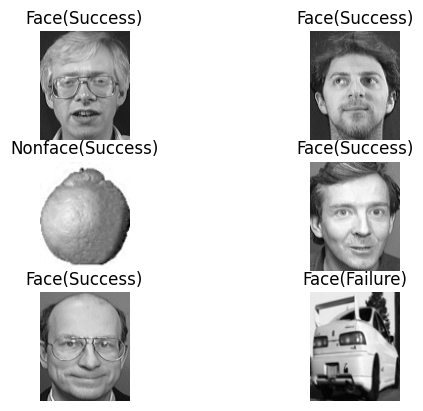

In [95]:
fig, axs = plt.subplots( 3, 2 )
for i in range( 3 ):
    for j in range( 2 ):
        index = np.random.randint( 0, len(test_set) )
        axs[i, j].imshow( test_set[index].reshape( 112, 92 ), cmap='gray' )
        prediction = knn.predict( new_test_set[index].reshape( 1, -1 ) )
        axs[i, j].set_title( ('Face' if prediction == 1 else 'Nonface') + ('(Failure)' if test_labels[index] != prediction else '(Success)') )
        axs[i, j].axis( 'off' )
plt.show()

### Classification using LDA

In [12]:
def LDA( training_set ):

    faces = training_set[ 0 : len(face_labels) // 2 ]
    nonfaces = training_set[ len(face_labels) // 2 : len(training_set) ]

    # Calculating the means of class-specific data (faces and non-faces)
    face_means = np.mean( faces, axis=0 )
    nonface_means = np.mean( nonfaces, axis=0 )

    # Reshaping to keep the dimensions consistent
    face_means = face_means.reshape( 1, 10304 )
    nonface_means = nonface_means.reshape( 1, 10304 )

    # Calculating the between-class scatter matrix
    B = np.dot( (face_means - nonface_means).T, (face_means - nonface_means) )

    # Centering the data
    centered_face_data = faces - face_means
    centered_nonface_data = nonfaces - nonface_means

    # Class scatter matrices
    Z1 = np.dot( centered_face_data.T, centered_face_data )
    Z2 = np.dot( centered_nonface_data.T, centered_nonface_data )

    # Calculating the within-class scatter matrix
    S = Z1 + Z2

    # Calculating the eigenvalues and eigenvectors of the generalized eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eig( np.dot( np.linalg.inv(S), B ) )

    eigenvalues = np.real( eigenvalues )
    eigenvectors = np.real( eigenvectors )

    # Sorting the eigenvalues and eigenvectors in descending order
    positions = eigenvalues.argsort()[::-1]
    sorted_eigenvalues = ( eigenvalues[positions] )
    sorted_eigenvectors = ( eigenvectors[:, positions] )

    # Calculating the new space
    new_space = sorted_eigenvectors[:, :2]

    return new_space

In [13]:
scores = []

for nonface_cnt in range( 50, len(nonface_data) + 1, 50 ):
    
    print( '[LDA] Running for', nonface_cnt, 'non-face images\n', nonface_cnt // 2, '-> training\n', nonface_cnt // 2, '-> test' )
    print( '----------------------------------------' )

    # Splitting the data into training and test sets according to the number of non-face images
    training_set, test_set, training_labels, test_labels = process_splits( face_data, nonface_data, face_labels, nonface_labels, nonface_cnt )
    
    # Calculating the new space using LDA
    new_space = LDA( training_set )

    # Centering the training set and test set
    centered_training_set = training_set - np.mean( training_set, axis=0 )
    centered_test_set = test_set - np.mean( test_set, axis=0 )

    # Projecting the training set and test set onto the new space
    new_training_set = np.dot( centered_training_set, new_space )
    new_test_set = np.dot( centered_test_set, new_space )

    # Fitting the KNN classifier to the training set
    knn = KNeighborsClassifier( n_neighbors=1 )
    knn.fit( new_training_set, training_labels.ravel() )

    # Predicting the test set results
    score = knn.score( new_test_set, test_labels.ravel() )
    
    # Appending the score to the scores list for plotting later
    scores.append( score )

    print( '[LDA] Accuracy for', nonface_cnt, 'non-face images =', '{:.2f}%\n'.format(score * 100))

[LDA] Running for 50 non-face images
 25 -> training
 25 -> test
----------------------------------------


NameError: name 'scores' is not defined